In [1]:
import os

In [2]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [3]:
from cmspinn.spinn_jax_viz import spinn_cube

In [4]:
parameters_path = '/userhome/jeon_mg/workspace/2023_007_zpinn/example/output/parameters.pickle'
params_path = '/userhome/jeon_mg/workspace/2023_007_zpinn/example/output/params_10000.pickle'

In [14]:
import numpy as np 
import pyvista as pv
import jax 
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import pickle

In [15]:
from cmspinn.spinn_jax import SPINN3d

In [16]:
with open(parameters_path, "rb") as f:
    parameters = pickle.load(f)

feat_sizes = parameters['feat_sizes']
r = parameters['r']
out_dim = parameters['out_dim']
Nx = parameters['Nx']
Ny = parameters['Ny']
Nz = parameters['Nz']
b_norm = parameters['b_norm']
pos_enc = parameters['pos_enc']
mlp = parameters['mlp']
n_max_x = parameters['n_max_x']
n_max_y = parameters['n_max_y']
n_max_z = parameters['n_max_z']

subkey = jax.random.PRNGKey(0)
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
model.init(
        subkey,
        jnp.ones((Nx, 1)),
        jnp.ones((Ny, 1)),
        jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)

with open(params_path, 'rb') as f:
    params = pickle.load(f)

x = jnp.linspace(0, n_max_x, Nx).reshape(-1, 1)
y = jnp.linspace(0, n_max_y, Ny).reshape(-1, 1)
z = jnp.linspace(0, n_max_z, Nz).reshape(-1, 1)
x, y, z = jax.lax.stop_gradient(x), jax.lax.stop_gradient(y), jax.lax.stop_gradient(z)

bx, by, bz = apply_fn(params, x, y, z)
b = jnp.stack([bx, by, bz], axis=-1)*b_norm

In [17]:
b.shape

(513, 257, 50, 3)

In [3]:
b.shape

(513, 257, 257, 3)

In [4]:
b = b[:, :, :50, :]
b.shape

(513, 257, 50, 3)

In [18]:
b_norm = 2500
B = np.load('data/outputs_12673.npy')*b_norm
B = B.transpose(1, 2, 3, 0)
B.shape

(513, 257, 50, 3)

In [19]:
from tools.ploting import plot_overview
from tools.metric import evaluate
from tools.metric_another import metrics

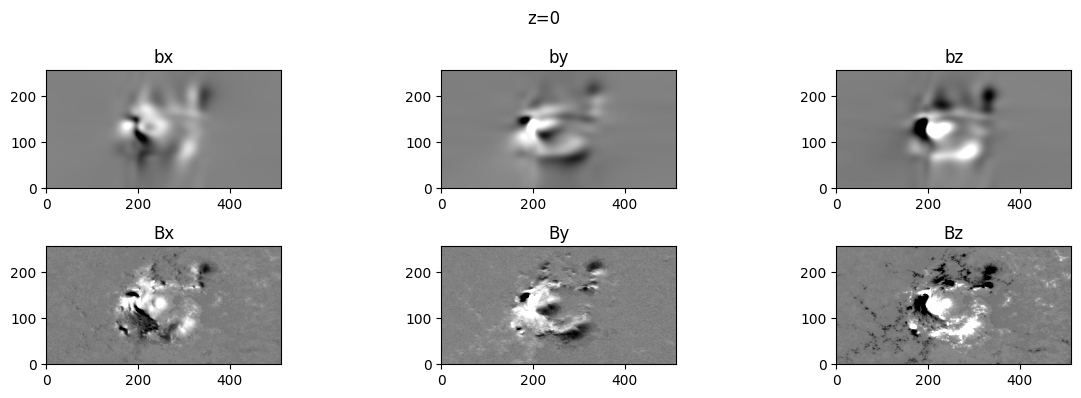

In [20]:
plot_overview(b, B, z=0, b_norm=1000)

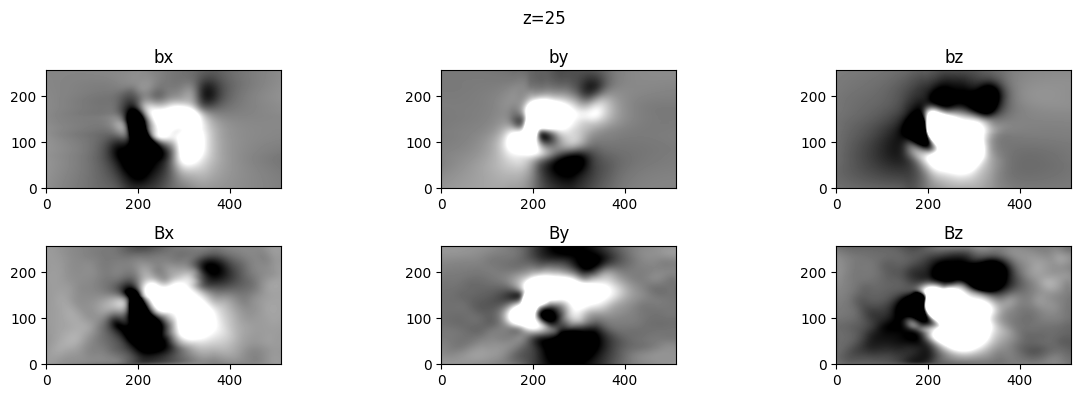

In [21]:
plot_overview(b, B, z=25, b_norm=100)

In [22]:
evaluate(b, B)

/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:63: RuntimeWarning: divide by zero encountered in divide
  E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:76: RuntimeWarning: invalid value encountered in divide
  result['sig_J_1e2_B'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/project/CNN_NF2/NF2_compare/tools/metric.py:81: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'C_vec': Array(0.91656506, dtype=float32),
 'C_cs': Array(nan, dtype=float32),
 "E_n'": 0.5492147622263865,
 "E_m'": -inf,
 'eps': 0.7568176883314378,
 'sig_J_1e2': 6.100144605015365,
 'sig_J_1e2_B': nan,
 'L1': 0.10136073,
 'L2': 0.041431956,
 'L1_B': nan,
 'L2_B': 175.9493615073281,
 'L2n': 0.19748329650610685,
 'L2n_B': 2414762027.1988177}

In [23]:
metrics(b, B)

{'c_vec': Array(0.91656524, dtype=float32),
 'c_cs': 0.7582204315062622,
 'c_cs_ep': Array(0.7585633, dtype=float32),
 "E_n'": 0.5492147622263865,
 "E_m'": -583.7065365997993,
 "E_m'_ep": -1033755.8388944188,
 'eps': 0.7568176883314378}

In [24]:
import matplotlib.pyplot as plt

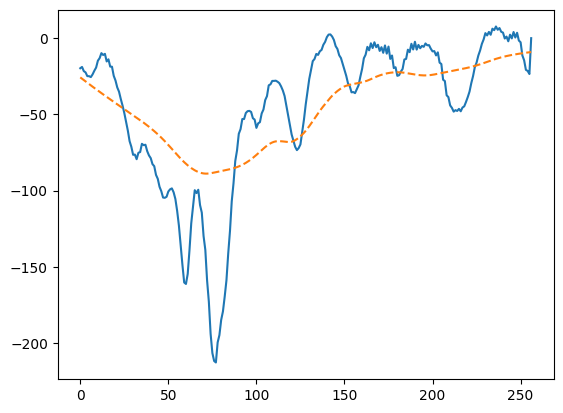

In [25]:
plt.plot(B[..., 5, 2][100, :])
plt.plot(b[..., 5, 2][100, :], '--')